## Setup & Konfigurasi Path

In [1]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm

from scipy import sparse
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report, roc_curve
)

from sklearn.metrics import average_precision_score

import matplotlib.pyplot as plt

TRAIN_DIR = "../datasets/MINDsmall_train"
DEV_DIR   = "../datasets/MINDsmall_dev"

TRAIN_NEWS = os.path.join(TRAIN_DIR, "news.csv")
TRAIN_BEH  = os.path.join(TRAIN_DIR, "behaviors.csv")

DEV_NEWS = os.path.join(DEV_DIR, "news.csv")
DEV_BEH  = os.path.join(DEV_DIR, "behaviors.csv")

NEWS_COLS = ["news_id","category","subcategory","title","abstract","url","title_entities","abstract_entities"]
BEH_COLS  = ["impression_id","user_id","time","history","impressions"]

# --- Pengaturan eksperimen ---
MAX_DEV_IMPRESSIONS = 10000
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# --- Text config ---
USE_ABSTRACT = True

# --- User profile config ---
USE_WEIGHTED_PROFILE = True

# --- TF-IDF config ---
MAX_FEATURES = 80000

print("Config:",
      "\n MAX_DEV_IMPRESSIONS =", MAX_DEV_IMPRESSIONS,
      "\n USE_ABSTRACT =", USE_ABSTRACT,
      "\n USE_WEIGHTED_PROFILE =", USE_WEIGHTED_PROFILE,
      "\n MAX_FEATURES =", MAX_FEATURES)

Config: 
 MAX_DEV_IMPRESSIONS = 10000 
 USE_ABSTRACT = True 
 USE_WEIGHTED_PROFILE = True 
 MAX_FEATURES = 80000


## Load CSV & Validasi Kolom

In [2]:
def load_news_csv(path: str) -> pd.DataFrame:
    df = pd.read_csv(path, dtype=str, na_filter=False)
    missing = [c for c in NEWS_COLS if c not in df.columns]
    if missing:
        raise ValueError(f"Kolom news hilang: {missing}. Cek file: {path}")
    return df

def load_behaviors_csv(path: str) -> pd.DataFrame:
    df = pd.read_csv(path, dtype=str, na_filter=False)
    missing = [c for c in BEH_COLS if c not in df.columns]
    if missing:
        raise ValueError(f"Kolom behaviors hilang: {missing}. Cek file: {path}")
    df["history"] = df["history"].fillna("")
    df["impressions"] = df["impressions"].fillna("")
    return df

news_train = load_news_csv(TRAIN_NEWS)
beh_train  = load_behaviors_csv(TRAIN_BEH)

news_dev = load_news_csv(DEV_NEWS)
beh_dev  = load_behaviors_csv(DEV_BEH)

print("train news:", news_train.shape, "train behaviors:", beh_train.shape)
print("dev news:", news_dev.shape, "dev behaviors:", beh_dev.shape)

news_train.head(2)

train news: (51282, 8) train behaviors: (156965, 5)
dev news: (42416, 8) dev behaviors: (73152, 5)


,news_id,category,subcategory,title,abstract,url,title_entities,abstract_entities
0,N55528,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the...",https://assets.msn.com/labs/mind/AAGH0ET.html,"[{""Label"": ""Prince Philip, Duke of Edinburgh"",...",[]
1,N19639,health,weightloss,50 Worst Habits For Belly Fat,These seemingly harmless habits are holding yo...,https://assets.msn.com/labs/mind/AAB19MK.html,"[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik...","[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik..."


## Build Text (title atau title+abstract)
default: `title + abstract`

In [3]:
def build_text(df_news: pd.DataFrame, use_abstract: bool = False) -> pd.Series:
    title = df_news["title"].astype(str).fillna("")
    if use_abstract:
        abstr = df_news["abstract"].astype(str).fillna("")
        return (title + " " + abstr).str.strip()
    return title.str.strip()

news_train["text"] = build_text(news_train, use_abstract=USE_ABSTRACT)
news_dev["text"]   = build_text(news_dev, use_abstract=USE_ABSTRACT)

news_train[["news_id","title","abstract","text"]].head(2)

,news_id,title,abstract,text
0,N55528,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the...","The Brands Queen Elizabeth, Prince Charles, an..."
1,N19639,50 Worst Habits For Belly Fat,These seemingly harmless habits are holding yo...,50 Worst Habits For Belly Fat These seemingly ...


## Gabungkan News TRAIN + DEV untuk membangun user profile
Kenapa? Karena **history pada dev sering berisi news dari train**.
Kita tetap fit TF‑IDF di TRAIN (agar tidak leakage), lalu transform ke gabungan (all).

In [4]:
# Gabungkan (drop duplicate news_id)
news_all = pd.concat([news_train, news_dev], ignore_index=True).drop_duplicates("news_id").reset_index(drop=True)

# Pastikan kolom text tersedia
if "text" not in news_all.columns:
    news_all["text"] = build_text(news_all, use_abstract=USE_ABSTRACT)

print("news_all:", news_all.shape, "unique_ids:", news_all["news_id"].nunique())

# TF-IDF fit pada TRAIN only
vectorizer = TfidfVectorizer(
    max_features=MAX_FEATURES,
    ngram_range=(1,2),
    stop_words="english",
    sublinear_tf=True,
    min_df=2,
    max_df=0.9
)

X_train = vectorizer.fit_transform(news_train["text"])
X_all   = vectorizer.transform(news_all["text"])

print("X_train:", X_train.shape)
print("X_all  :", X_all.shape)

all_ids = news_all["news_id"].tolist()
all2idx = {nid:i for i,nid in enumerate(all_ids)}

# Untuk meta display
meta_all = news_all.set_index("news_id")[["category","subcategory","title"]].to_dict(orient="index")

news_all: (65238, 9) unique_ids: 65238
X_train: (51282, 80000)
X_all  : (65238, 80000)


## Parsing history & impressions

In [5]:
def parse_history(hist_str: str):
    if not hist_str:
        return []
    return hist_str.split()

def parse_impressions(impr_str: str):
    out = []
    if not impr_str:
        return out
    for tok in impr_str.split():
        if "-" not in tok:
            continue
        nid, lab = tok.rsplit("-", 1)
        try:
            out.append((nid, int(lab)))
        except:
            continue
    return out

# sanity check
row = beh_dev.iloc[0]
print("history sample:", parse_history(row["history"])[:5])
print("impressions sample:", parse_impressions(row["impressions"])[:5])

history sample: ['N55189', 'N46039', 'N51741', 'N53234', 'N11276']
impressions sample: [('N28682', 0), ('N48740', 0), ('N31958', 1), ('N34130', 0), ('N6916', 0)]


## User Profile Vector (mean / weighted)

In [6]:
def user_profile_vector_mean(hist_ids, X_news, id2idx):
    idxs = [id2idx[n] for n in hist_ids if n in id2idx]
    if not idxs:
        return None
    uvec = X_news[idxs].sum(axis=0) / len(idxs)
    return np.asarray(uvec)

def user_profile_vector_weighted(hist_ids, X_news, id2idx):
    idxs = [id2idx[n] for n in hist_ids if n in id2idx]
    if not idxs:
        return None

    w = np.linspace(1.0, 2.0, num=len(idxs)).astype(np.float32)
    M = X_news[idxs] 
    uvec = (M.multiply(w[:, None])).sum(axis=0) / w.sum()
    return np.asarray(uvec)

def get_user_profile(hist_ids):
    if USE_WEIGHTED_PROFILE:
        return user_profile_vector_weighted(hist_ids, X_all, all2idx)
    return user_profile_vector_mean(hist_ids, X_all, all2idx)

## Scoring Cosine Similarity — **Batch**

In [7]:
def score_candidates_batch(uvec, cand_ids, X_news, id2idx):
    scores = np.zeros(len(cand_ids), dtype=np.float32)
    if uvec is None:
        return scores

    idxs = [id2idx.get(n, None) for n in cand_ids]
    valid_pos = [j for j,i in enumerate(idxs) if i is not None]
    if not valid_pos:
        return scores

    cols = [idxs[j] for j in valid_pos]
    M = X_news[cols]
    sim = cosine_similarity(uvec, M)[0]
    for j, s in zip(valid_pos, sim):
        scores[j] = float(s)
    return scores

## Build dataset klasifikasi dari DEV impressions
Output: `user_id, news_id, y_true, y_score`.
Karena kita pakai `X_all` + `all2idx`, history & candidate akan lebih banyak yang match.

In [8]:
def build_labeled_from_dev(beh_df, max_impressions=5000):
    rows = []
    used = 0

    it = beh_df.iterrows()
    total = min(len(beh_df), max_impressions)

    for _, r in tqdm(it, total=total, desc="Build labeled dev (v2)"):
        user_id = r["user_id"]
        hist_ids = parse_history(r["history"])
        cand = parse_impressions(r["impressions"])
        if not cand:
            continue

        cand_ids = [x[0] for x in cand]
        y_true   = [x[1] for x in cand]

        uvec = get_user_profile(hist_ids)
        y_score = score_candidates_batch(uvec, cand_ids, X_all, all2idx)

        for nid, yt, ys in zip(cand_ids, y_true, y_score):
            rows.append((user_id, nid, int(yt), float(ys)))

        used += 1
        if used >= max_impressions:
            break

    df = pd.DataFrame(rows, columns=["user_id","news_id","y_true","y_score"])
    return df, used

dev_labeled, used = build_labeled_from_dev(beh_dev, max_impressions=MAX_DEV_IMPRESSIONS)

print("impressions used:", used)
print("rows:", dev_labeled.shape)
dev_labeled.head()

Build labeled dev (v2): 100%|█████████▉| 9999/10000 [00:14<00:00, 680.45it/s]


impressions used: 10000
rows: (375609, 4)


,user_id,news_id,y_true,y_score
0,U80234,N28682,0,0.012061
1,U80234,N48740,0,0.022959
2,U80234,N31958,1,0.019397
3,U80234,N34130,0,0.002089
4,U80234,N6916,0,0.012724


## Threshold selection (optimize F1)
Kita scan threshold 0..1 dan pilih yang memaksimalkan F1.

In [9]:
def find_best_threshold(y_true, y_score, thresholds=None):
    if thresholds is None:
        thresholds = np.linspace(0, 1, 201)
    best = {"thr": 0.5, "f1": -1, "precision": 0, "recall": 0, "acc": 0}
    for thr in thresholds:
        y_pred = (y_score >= thr).astype(int)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        if f1 > best["f1"]:
            best["thr"] = float(thr)
            best["f1"] = float(f1)
            best["precision"] = float(precision_score(y_true, y_pred, zero_division=0))
            best["recall"] = float(recall_score(y_true, y_pred, zero_division=0))
            best["acc"] = float(accuracy_score(y_true, y_pred))
    return best

y_true = dev_labeled["y_true"].values.astype(int)
y_score = dev_labeled["y_score"].values.astype(float)

best = find_best_threshold(y_true, y_score)
best

{'thr': 0.04,
 'f1': 0.12036993568377072,
 'precision': 0.09397104636247022,
 'recall': 0.16739570411960566,
 'acc': 0.900231357608577}

## Evaluasi metrik (sesuai dosen) + PR‑AUC (opsional)
- Accuracy, Precision, Recall, F1
- AUC (ROC)
- PR‑AUC / Average Precision

In [10]:
THR = best["thr"]
y_pred = (y_score >= THR).astype(int)

acc  = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, zero_division=0)
rec  = recall_score(y_true, y_pred, zero_division=0)
f1   = f1_score(y_true, y_pred, zero_division=0)

auc = roc_auc_score(y_true, y_score) if len(np.unique(y_true)) > 1 else 0.5
pr_auc = average_precision_score(y_true, y_score)

metrics_df = pd.DataFrame([{
    "threshold": THR,
    "accuracy": acc,
    "precision": prec,
    "recall": rec,
    "f1_score": f1,
    "auc": auc,
    "pr_auc": pr_auc,
    "rows": len(dev_labeled),
    "impressions_used": used
}])

metrics_df

,threshold,accuracy,precision,recall,f1_score,auc,pr_auc,rows,impressions_used
0,0.04,0.900231,0.093971,0.167396,0.12037,0.586422,0.06935,375609,10000


### Confusion Matrix + Classification Report

In [11]:
cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(cm, index=["True_0","True_1"], columns=["Pred_0","Pred_1"])
cm_df

,Pred_0,Pred_1
True_0,335571,24721
True_1,12753,2564


In [12]:
print(classification_report(y_true, y_pred, digits=4, zero_division=0))

              precision    recall  f1-score   support

           0     0.9634    0.9314    0.9471    360292
           1     0.0940    0.1674    0.1204     15317

    accuracy                         0.9002    375609
   macro avg     0.5287    0.5494    0.5337    375609
weighted avg     0.9279    0.9002    0.9134    375609



### ROC Curve

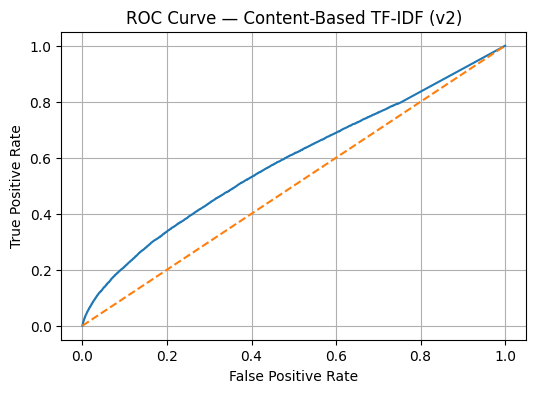

AUC: 0.5864217599811922


In [13]:
fpr, tpr, thr = roc_curve(y_true, y_score)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1], linestyle="--")
plt.title("ROC Curve — Content-Based TF‑IDF (v2)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(True)
plt.show()

print("AUC:", auc)

### PR Curve ringkas
PR-AUC (Average Precision) sering lebih relevan saat kelas positif sedikit.

In [14]:
# PR-AUC sudah dihitung sebagai pr_auc
print("PR-AUC (Average Precision):", pr_auc)

PR-AUC (Average Precision): 0.06934968867842616


## Simpan artifacts untuk GUI
Simpan vectorizer + X_all agar GUI bisa scoring realtime.
Catatan: X_all bisa besar, tapi masih manageable untuk MIND-small.

In [15]:
import pickle

ARTIFACT_DIR = "../notebooks/artifacts_classification_v2"
os.makedirs(ARTIFACT_DIR, exist_ok=True)

with open(os.path.join(ARTIFACT_DIR, "tfidf_vectorizer.pkl"), "wb") as f:
    pickle.dump(vectorizer, f)

with open(os.path.join(ARTIFACT_DIR, "news_all.pkl"), "wb") as f:
    pickle.dump(news_all, f)

with open(os.path.join(ARTIFACT_DIR, "all2idx.pkl"), "wb") as f:
    pickle.dump(all2idx, f)

sparse.save_npz(os.path.join(ARTIFACT_DIR, "X_all_tfidf.npz"), X_all)

metrics_df.to_csv(os.path.join(ARTIFACT_DIR, "metrics.csv"), index=False)

print("Saved artifacts to:", ARTIFACT_DIR)

Saved artifacts to: ../notebooks/artifacts_classification_v2


## Demo Top‑N
Walau evaluasi klasifikasi, demo bisa tampilkan Top‑N berdasarkan skor tertinggi dari salah satu impression baris user.

In [16]:
def recommend_topn_from_one_row(user_id: str, beh_df: pd.DataFrame, top_n: int = 10):
    rows = beh_df[beh_df["user_id"] == user_id]
    if rows.empty:
        return pd.DataFrame()

    r = rows.iloc[0]
    hist_ids = parse_history(r["history"])
    cand = parse_impressions(r["impressions"])
    if not cand:
        return pd.DataFrame()

    cand_ids = [x[0] for x in cand]
    y_true_  = [x[1] for x in cand]

    uvec = get_user_profile(hist_ids)
    y_score_ = score_candidates_batch(uvec, cand_ids, X_all, all2idx)
    y_pred_  = (y_score_ >= THR).astype(int)

    out = []
    for nid, yt, ys, yp in zip(cand_ids, y_true_, y_score_, y_pred_):
        m = meta_all.get(nid, {})
        out.append({
            "news_id": nid,
            "score": float(ys),
            "pred": int(yp),
            "true": int(yt),
            "category": m.get("category",""),
            "subcategory": m.get("subcategory",""),
            "title": m.get("title","")
        })

    return pd.DataFrame(out).sort_values("score", ascending=False).head(top_n)

import random
u = random.choice(beh_dev["user_id"].tolist())
print("Demo user:", u)
recommend_topn_from_one_row(u, beh_dev, top_n=10)

Demo user: U51872


,news_id,score,pred,true,category,subcategory,title
35,N42233,0.058934,1,0,news,newsus,"After four years of controversy, embattled Pal..."
17,N33397,0.043600,1,0,news,newscrime,5 arrested in connection with deadly shooting ...
3,N2852,0.039127,0,0,finance,finance-companies,The world's only $100 billion utility owes its...
18,N5940,0.033751,0,0,lifestyle,lifestyleroyals,Meghan Markle and Hillary Clinton Secretly Spe...
29,N37055,0.032929,0,0,news,newsworld,"At NATO summit, Trump to stress US allies' def..."
7,N4331,0.031813,0,0,travel,internationaltravel,Five Great Holiday Cruises Worth Taking
6,N6194,0.030738,0,0,health,health-news,New Trump rule to make more health care rates ...
31,N39393,0.029840,0,0,movies,movies-celebrity,Christopher Reeve's Son Remembers Dad 15 Years...
19,N36779,0.029112,0,0,news,newsus,South Carolina teen gets life in prison for de...
37,N31958,0.025888,0,1,sports,football_nfl,Opinion: Colin Kaepernick is about to get what...
